In [1]:
import os
os.listdir('/kaggle/input/defects-class-and-location')

['label', 'images']

In [2]:
import glob
images_path = glob.glob('/kaggle/input/defects-class-and-location/images/images/*/*.jpg')
print(len(images_path))
images_path[:9]

2306


['/kaggle/input/defects-class-and-location/images/images/inclusion/img_05_425243500_00898.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_03_3402617100_00131.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_06_425508200_00471.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_08_425506100_01068.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_03_3402617100_00120.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_06_4405000800_01031.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_04_424714400_00324.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_06_425237000_00528.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_02_425383400_00356.jpg']

In [3]:
xmls_path = glob.glob('/kaggle/input/defects-class-and-location/label/label/*.xml')
print(len(xmls_path))
xmls_path[:9]

2280


['/kaggle/input/defects-class-and-location/label/label/img_01_425241700_00384.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_06_425505000_00050.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_06_3436814300_00056.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_07_425390900_00077.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_01_425005700_00501.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_07_4406743300_00036.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_08_436164500_01565.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_02_425501900_00018.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_01_425503500_00017.xml']

In [4]:
xmls_data = [p.split('/')[-1].split('.')[0] for p in xmls_path]
images_data = [img for img in images_path if (img.split('/')[-1].split)('.jpg')[0] in xmls_data]

len(images_data),len(xmls_path)


(2280, 2280)

In [5]:
xmls_path.sort(key=lambda x: x.split("/")[-1].split('.xml')[0])
images_data.sort(key=lambda x: x.split("/")[-1].split('.jpg')[0])
xmls_path[:9],images_data[:9]

(['/kaggle/input/defects-class-and-location/label/label/img_01_3402617700_00001.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3402617700_01009.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3436789500_00004.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3436814600_00259.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3436815300_00473.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3436815300_00477.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3436815300_00478.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3437011300_00918.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_424799300_01133.xml'],
 ['/kaggle/input/defects-class-and-location/images/images/crescent_gap/img_01_3402617700_00001.jpg',
  '/kaggle/input/defects-class-and-location/images/images/crescent_gap/img_01_3402617700_01009.jpg',
  '/kaggle/input/defects

In [6]:
import xml.etree.ElementTree as ET
import glob
import re
import torch

def encoded_vec(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    name_counts = {}
    vector = torch.zeros(10, dtype=torch.float32)

    for obj in root.findall('.//object'):
        names = obj.findall('.//name')
        
        if names:
            for name in names:
                digit_match = re.search(r'\d+', name.text)
                
                if digit_match:
                    digit = int(digit_match.group())
                    vector[digit-1] = 1

    return vector

labels = []
for xml_path in xmls_path:
    label = encoded_vec(xml_path)
    labels.append(label)
    
labels_tensor = torch.stack(labels)
print(labels_tensor)


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])


In [7]:
zero_rows_mask = torch.all(labels_tensor == 0, dim=1)

zero_rows_indices = torch.nonzero(zero_rows_mask).squeeze()

print("Индексы строк, где все элементы равны нулю:", zero_rows_indices)

Индексы строк, где все элементы равны нулю: tensor([], dtype=torch.int64)


In [8]:
#pip install torch torchvision

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        #label = torch.tensor(self.labels[idx], dtype=torch.float32)
        label = self.labels[idx].clone().detach().to(torch.float32)
        
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_dataset = CustomDataset(images_data, labels_tensor, transform=transform)

train_size = int(0.7 * len(custom_dataset))
val_test_size = len(custom_dataset) - train_size
train_dataset, remaining_dataset = torch.utils.data.random_split(custom_dataset, [train_size, val_test_size])

val_size = int(0.5 * len(remaining_dataset))
test_size = len(remaining_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(remaining_dataset, [val_size, test_size])

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# for img, label in train_dataloader:
#     # img is a batch of preprocessed images
#     # label is a batch of labels
#     # Your training logic goes here
#     pass


In [10]:
first_batch = next(iter(train_dataloader))

#print(f"Sample:\n{batch['sample']}")
#print(f"Target:\n{batch['target']}")

for index, value in enumerate(first_batch):
    print(f"Element {index}: {value}")


Element 0: tensor([[[[-0.7993, -0.7993, -0.7993,  ..., -0.6623, -0.6794, -0.6965],
          [-0.7822, -0.7822, -0.7822,  ..., -0.6623, -0.6623, -0.6965],
          [-0.7822, -0.7822, -0.7650,  ..., -0.6452, -0.6623, -0.6794],
          ...,
          [-0.7822, -0.7650, -0.7650,  ..., -0.7308, -0.6965, -0.6794],
          [-0.7822, -0.7650, -0.7650,  ..., -0.7137, -0.6965, -0.6965],
          [-0.7822, -0.7822, -0.7650,  ..., -0.7137, -0.6965, -0.6965]],

         [[-0.6877, -0.6877, -0.6877,  ..., -0.5476, -0.5651, -0.5826],
          [-0.6702, -0.6702, -0.6702,  ..., -0.5476, -0.5476, -0.5826],
          [-0.6702, -0.6702, -0.6527,  ..., -0.5301, -0.5476, -0.5651],
          ...,
          [-0.6702, -0.6527, -0.6527,  ..., -0.6176, -0.5826, -0.5651],
          [-0.6702, -0.6527, -0.6527,  ..., -0.6001, -0.5826, -0.5826],
          [-0.6702, -0.6702, -0.6527,  ..., -0.6001, -0.5826, -0.5826]],

         [[-0.4624, -0.4624, -0.4624,  ..., -0.3230, -0.3404, -0.3578],
          [-0.4450,

In [11]:
first_batch[0].shape

torch.Size([128, 3, 224, 224])

In [12]:
import torch
import torchvision.models as models
import torch.nn as nn

pretrained_model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.4MB/s]


In [13]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
#number_features = pretrained_model.fc.in_features
num_classes = 10
pretrained_model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes),
    #nn.ModuleList([nn.Sigmoid() for _ in range(10)])
    nn.Sigmoid()
    #nn.LogSoftmax(dim=1)
)
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
import torch.optim as optim
#Loss = nn.CrossEntropyLoss()
Loss = nn.BCELoss()
#optimizer = optim.SGD(pretrained_model.parameters(), lr=0.01)
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.01,  momentum=0.9)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
def test(model, loader):
    loss_log, acc_log, prec_log, recall_log, f1_log = [], [], [], [], []

    model.eval()

    with torch.no_grad():
        for data, target in loader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = Loss(outputs, labels)
            outputs = [[1 if val > 0.5 else 0 for val in inner_list] for inner_list in outputs]
            outputs = torch.tensor(outputs).float()

            accuracy = accuracy_score(y_true = labels.cpu().detach().numpy(), y_pred = outputs.cpu().detach().numpy(), normalize = True)
            precision = precision_score(y_true = labels.cpu().detach().numpy(), y_pred = outputs.cpu().detach().numpy(), average = 'samples')
            recall = recall_score(y_true = labels.cpu().detach().numpy(), y_pred = outputs.cpu().detach().numpy(), average = 'samples')
            f1 = f1_score(y_true = labels.cpu().detach().numpy(), y_pred = outputs.cpu().detach().numpy(), average = 'samples')

            loss_log.append(loss.item())
            prec_log.append(precision.item())
            acc_log.append(accuracy.item())
            recall_log.append(recall.item())
            f1_log.append(f1.item())

    return np.mean(loss_log), np.mean(prec_log),np.mean(acc_log), np.mean(recall_log), np.mean(f1_log)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
def train_epoch(model, optimizer, train_loader):
    loss_log, acc_log, prec_log, recall_log, f1_log = [], [], [], [], []

    model.train()
    
    for data, target in train_loader:
        inputs, labels = data.to(device), target.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = Loss(outputs, labels)
        outputs = [[1 if val > 0.5 else 0 for val in inner_list] for inner_list in outputs]
        outputs = torch.tensor(outputs).float()
        #print(f"Outputs {outputs}")
        #print(f"Labels {labels}")

        #precision, recall, f1, accuracy = calculate_metrics(outputs, labels)

        accuracy = accuracy_score(y_true = labels.cpu().detach().numpy(), y_pred = outputs.cpu().detach().numpy(), normalize = True)
        precision = precision_score(y_true = labels.cpu().detach().numpy(), y_pred = outputs.cpu().detach().numpy(), average = 'samples')
        recall = recall_score(y_true = labels.cpu().detach().numpy(), y_pred = outputs.cpu().detach().numpy(), average = 'samples')
        f1 = f1_score(y_true = labels.cpu().detach().numpy(), y_pred = outputs.cpu().detach().numpy(), average = 'samples')

        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())
        acc_log.append(accuracy.item())
        prec_log.append(precision.item())
        recall_log.append(recall.item())
        f1_log.append(f1.item())

    return loss_log, acc_log, prec_log, recall_log, f1_log


In [18]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, train_prec_log, train_recall_log, train_f1_log = [], [], [], [], []
    val_loss_log, val_acc_log, val_prec_log, val_recall_log, val_f1_log = [], [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc, train_prec, train_recall, train_f1 = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc, val_prec, val_recall, val_f1 = test(model, val_loader)
        
        train_loss_log.append(np.mean(train_loss))
        train_acc_log.append(np.mean(train_acc))
        train_prec_log.append(np.mean(train_prec))
        train_recall_log.append(np.mean(train_recall))
        train_f1_log.append(np.mean(train_f1))
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        val_prec_log.append(val_prec)
        val_recall_log.append(val_recall)
        val_f1_log.append(val_f1)

        print(f"Epoch {epoch}")
        print(f" Train loss: {np.mean(train_loss)}, Train accuracy: {np.mean(train_acc)}, Train precision: {np.mean(train_prec)}, Train recall: {np.mean(train_recall)}, Train F1: {np.mean(train_f1)}")
        print(f" Validation loss: {val_loss}, Validation accuracy: {val_acc}, Validation precision: {val_prec}, Validation recall: {val_recall}, Validation F1: {val_f1}\n")
        
        if scheduler is not None:
            scheduler.step()
            
    return train_loss_log, train_acc_log, train_prec_log, train_recall_log, train_f1_log, val_loss_log, val_acc_log, val_prec_log, val_recall_log, val_f1_log


In [19]:
num_epochs = 30
train_loss_log, train_acc_log, train_prec_log, train_recall_log, train_f1_log, val_loss_log, val_acc_log, val_prec_log, val_recall_log, val_f1_log = train(pretrained_model, optimizer, num_epochs, train_dataloader, val_dataloader)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 0
 Train loss: 0.5552913454862741, Train accuracy: 0.01622596153846154, Train precision: 0.06890381753663004, Train recall: 0.1590544871794872, Train F1: 0.08232284208846709
 Validation loss: 0.4019273022810618, Validation accuracy: 0.0, Validation precision: 0.0, Validation recall: 0.0, Validation F1: 0.0



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 1
 Train loss: 0.3604061145048875, Train accuracy: 0.01594551282051282, Train precision: 0.019030448717948716, Train recall: 0.017274305555555557, Train F1: 0.017788461538461538
 Validation loss: 0.35600754618644714, Validation accuracy: 0.0, Validation precision: 0.0, Validation recall: 0.0, Validation F1: 0.0



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 2
 Train loss: 0.3372458792649783, Train accuracy: 0.0845352564102564, Train precision: 0.09054487179487179, Train recall: 0.0871895032051282, Train F1: 0.08818108974358974
 Validation loss: 0.3178265889485677, Validation accuracy: 0.014292635658914728, Validation precision: 0.014292635658914728, Validation recall: 0.014292635658914728, Validation F1: 0.014292635658914728



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 3
 Train loss: 0.3188476333251366, Train accuracy: 0.09603365384615385, Train precision: 0.10572916666666667, Train recall: 0.10073116987179488, Train F1: 0.10233707264957267
 Validation loss: 0.30181658267974854, Validation accuracy: 0.11815649224806202, Validation precision: 0.11294815891472869, Validation recall: 0.11555232558139535, Validation F1: 0.1164203811369509



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 4
 Train loss: 0.29835198475764346, Train accuracy: 0.17628205128205127, Train precision: 0.1838741987179487, Train recall: 0.18052884615384615, Train F1: 0.18154380341880338
 Validation loss: 0.28248002131779987, Validation accuracy: 0.23631298449612403, Validation precision: 0.2311046511627907, Validation recall: 0.23370881782945738, Validation F1: 0.2345768733850129



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 5
 Train loss: 0.2782162932249216, Train accuracy: 0.21310096153846156, Train precision: 0.23060897435897437, Train recall: 0.22175480769230768, Train F1: 0.22467280982905985
 Validation loss: 0.26235077778498334, Validation accuracy: 0.24933381782945738, Validation precision: 0.24412548449612403, Validation recall: 0.2467296511627907, Validation F1: 0.24759770671834624



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 6
 Train loss: 0.2607134465987866, Train accuracy: 0.24006410256410254, Train precision: 0.27838541666666666, Train recall: 0.2591746794871795, Train F1: 0.26531116452991454
 Validation loss: 0.24431381622950235, Validation accuracy: 0.30650436046511625, Validation precision: 0.2518774224806202, Validation recall: 0.277671794250646, Validation F1: 0.2867328811369509



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 7
 Train loss: 0.23611530088461363, Train accuracy: 0.28970352564102564, Train precision: 0.38952323717948717, Train recall: 0.33973357371794866, Train F1: 0.3554620726495727
 Validation loss: 0.2297823280096054, Validation accuracy: 0.3649467054263566, Validation precision: 0.2675024224806202, Validation recall: 0.31211139373385005, Validation F1: 0.3283087047803617



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 8
 Train loss: 0.2191311900432293, Train accuracy: 0.3301682692307692, Train precision: 0.4262820512820513, Train recall: 0.38238848824786326, Train F1: 0.39496527777777773
 Validation loss: 0.2119360864162445, Validation accuracy: 0.4161518895348837, Validation precision: 0.32848837209302323, Validation recall: 0.3769783591731266, Validation F1: 0.38663194444444443



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 9
 Train loss: 0.2015004845765921, Train accuracy: 0.39066506410256413, Train precision: 0.4896634615384615, Train recall: 0.45846020299145296, Train F1: 0.46382211538461543
 Validation loss: 0.20939221481482187, Validation accuracy: 0.44927931201550386, Validation precision: 0.3439922480620155, Validation recall: 0.449501372739018, Validation F1: 0.43723958333333335



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 10
 Train loss: 0.1817858310846182, Train accuracy: 0.43493589743589745, Train precision: 0.5185296474358975, Train recall: 0.5015324519230769, Train F1: 0.5014663461538461
 Validation loss: 0.18568691114584604, Validation accuracy: 0.4577277131782946, Validation precision: 0.3725775193798449, Validation recall: 0.4609879683462532, Validation F1: 0.45006661821705424



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 11
 Train loss: 0.16801577921097094, Train accuracy: 0.4663060897435897, Train precision: 0.5338942307692307, Train recall: 0.5231670673076922, Train F1: 0.5217334401709401
 Validation loss: 0.16944284737110138, Validation accuracy: 0.46690285852713176, Validation precision: 0.38051114341085274, Validation recall: 0.4794593830749354, Validation F1: 0.464952761627907



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 12
 Train loss: 0.15409729457818544, Train accuracy: 0.49603365384615383, Train precision: 0.5739182692307693, Train recall: 0.5733740651709403, Train F1: 0.5660069444444443
 Validation loss: 0.15886651972929636, Validation accuracy: 0.5006359011627907, Validation precision: 0.4090964147286822, Validation recall: 0.49889979005167956, Validation F1: 0.4917615471576227



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 13
 Train loss: 0.14113340698755705, Train accuracy: 0.5401842948717949, Train precision: 0.6245392628205129, Train recall: 0.6238281250000001, Train F1: 0.6156356837606837
 Validation loss: 0.15544092655181885, Validation accuracy: 0.5596233042635659, Validation precision: 0.4791061046511628, Validation recall: 0.550094880490956, Validation F1: 0.5473332525839792



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 14
 Train loss: 0.13009548817689603, Train accuracy: 0.6039663461538461, Train precision: 0.6790865384615383, Train recall: 0.6729567307692308, Train F1: 0.6687433226495726
 Validation loss: 0.14082623024781546, Validation accuracy: 0.6285731589147286, Validation precision: 0.545421511627907, Validation recall: 0.6287750322997415, Validation F1: 0.6216367894056848



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 15
 Train loss: 0.12173063422624882, Train accuracy: 0.6229967948717949, Train precision: 0.7063902243589743, Train recall: 0.705315170940171, Train F1: 0.6977319902319901
 Validation loss: 0.14055152237415314, Validation accuracy: 0.6278766957364341, Validation precision: 0.5492369186046512, Validation recall: 0.6215782461240309, Validation F1: 0.6178193636950904



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 16
 Train loss: 0.10954021891722313, Train accuracy: 0.6706730769230769, Train precision: 0.7504607371794871, Train recall: 0.7454427083333334, Train F1: 0.7397836538461539
 Validation loss: 0.1317013824979464, Validation accuracy: 0.6538578003875969, Validation precision: 0.5700702519379846, Validation recall: 0.641079215116279, Validation F1: 0.6403484334625323



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 17
 Train loss: 0.10310348123311996, Train accuracy: 0.7049679487179487, Train precision: 0.7768028846153846, Train recall: 0.7695813301282052, Train F1: 0.7665531517094017
 Validation loss: 0.12392484645048778, Validation accuracy: 0.7077579941860465, Validation precision: 0.606468023255814, Validation recall: 0.6930414244186046, Validation F1: 0.6914425872093023



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 18
 Train loss: 0.09925910429312633, Train accuracy: 0.7054086538461538, Train precision: 0.7866586538461539, Train recall: 0.7897936698717949, Train F1: 0.7800623855311355
 Validation loss: 0.12232645601034164, Validation accuracy: 0.6960695251937984, Validation precision: 0.6077398255813954, Validation recall: 0.6934754521963824, Validation F1: 0.6863311531007752



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 19
 Train loss: 0.09207814874557349, Train accuracy: 0.7384214743589743, Train precision: 0.8176482371794871, Train recall: 0.8070512820512821, Train F1: 0.804667467948718
 Validation loss: 0.11712045719226201, Validation accuracy: 0.7337088178294574, Validation precision: 0.6428052325581395, Validation recall: 0.7155503068475452, Validation F1: 0.7166222545219637



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 20
 Train loss: 0.0861178905918048, Train accuracy: 0.7739182692307692, Train precision: 0.8434895833333333, Train recall: 0.839823717948718, Train F1: 0.8346955128205129
 Validation loss: 0.12176592151323955, Validation accuracy: 0.7168422965116279, Validation precision: 0.6285125968992248, Validation recall: 0.7112100290697674, Validation F1: 0.7061490633074935



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 21
 Train loss: 0.0805167739207928, Train accuracy: 0.7896634615384616, Train precision: 0.8614983974358974, Train recall: 0.8515024038461539, Train F1: 0.8499131944444444
 Validation loss: 0.11043383926153183, Validation accuracy: 0.7701065891472868, Validation precision: 0.6830789728682171, Validation recall: 0.763172238372093, Validation F1: 0.7589793281653746



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 22
 Train loss: 0.07539249010957204, Train accuracy: 0.794911858974359, Train precision: 0.8728365384615384, Train recall: 0.8632712339743591, Train F1: 0.8609304410866911
 Validation loss: 0.11226129035154979, Validation accuracy: 0.7966630329457365, Validation precision: 0.6921027131782945, Validation recall: 0.7804425064599482, Validation F1: 0.7789203811369508



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 23
 Train loss: 0.0697928647009226, Train accuracy: 0.8221554487179487, Train precision: 0.8926282051282051, Train recall: 0.8815304487179488, Train F1: 0.8806129807692307
 Validation loss: 0.11218322316805522, Validation accuracy: 0.7720142926356589, Validation precision: 0.6856225775193798, Validation recall: 0.757065568475452, Validation F1: 0.7568556201550387



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 24
 Train loss: 0.06606278253289369, Train accuracy: 0.8307692307692308, Train precision: 0.8975360576923077, Train recall: 0.8868623130341879, Train F1: 0.8861752136752137
 Validation loss: 0.11499936878681183, Validation accuracy: 0.7629602713178295, Validation precision: 0.6623062015503876, Validation recall: 0.7476078003875969, Validation F1: 0.7464328972868217



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 25
 Train loss: 0.06289375458772366, Train accuracy: 0.8371794871794871, Train precision: 0.9030248397435898, Train recall: 0.8966279380341882, Train F1: 0.893573717948718
 Validation loss: 0.10893714427947998, Validation accuracy: 0.8032642926356589, Validation precision: 0.7051841085271318, Validation recall: 0.7911518895348837, Validation F1: 0.7884629360465115



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 26
 Train loss: 0.059285762504889414, Train accuracy: 0.8524038461538462, Train precision: 0.9231570512820514, Train recall: 0.907248263888889, Train F1: 0.9090273962148961
 Validation loss: 0.10694597164789836, Validation accuracy: 0.8084120639534884, Validation precision: 0.7103318798449613, Validation recall: 0.7960372254521962, Validation F1: 0.7932432978036174



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 27
 Train loss: 0.05721030756831169, Train accuracy: 0.8584935897435897, Train precision: 0.9198317307692309, Train recall: 0.9046874999999999, Train F1: 0.9069831730769231
 Validation loss: 0.1059466724594434, Validation accuracy: 0.8006904069767442, Validation precision: 0.7129966085271318, Validation recall: 0.7840055717054263, Validation F1: 0.7850109011627907



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 28
 Train loss: 0.05233559499566372, Train accuracy: 0.8703125, Train precision: 0.9303285256410257, Train recall: 0.9171908386752136, Train F1: 0.9184334935897435
 Validation loss: 0.10514496763547261, Validation accuracy: 0.8103197674418605, Validation precision: 0.708999515503876, Validation recall: 0.7975411821705425, Validation F1: 0.7948623223514212



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 29
 Train loss: 0.04873119638516353, Train accuracy: 0.8847355769230769, Train precision: 0.9376201923076923, Train recall: 0.9242855235042735, Train F1: 0.9264779838217337
 Validation loss: 0.11099378267923991, Validation accuracy: 0.801265746124031, Validation precision: 0.6908309108527132, Validation recall: 0.7876191052971576, Validation F1: 0.7841589954780362



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
pretrained_model.eval()

test_loss, test_acc, test_prec, test_recall, test_f1 = test(pretrained_model, test_dataloader)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_prec}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.10970983157555263
Test Accuracy: 0.7904251453488372
Test Precision: 0.7014292635658915
Test Recall: 0.7856306524547803
Test F1 Score: 0.7797157622739018


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


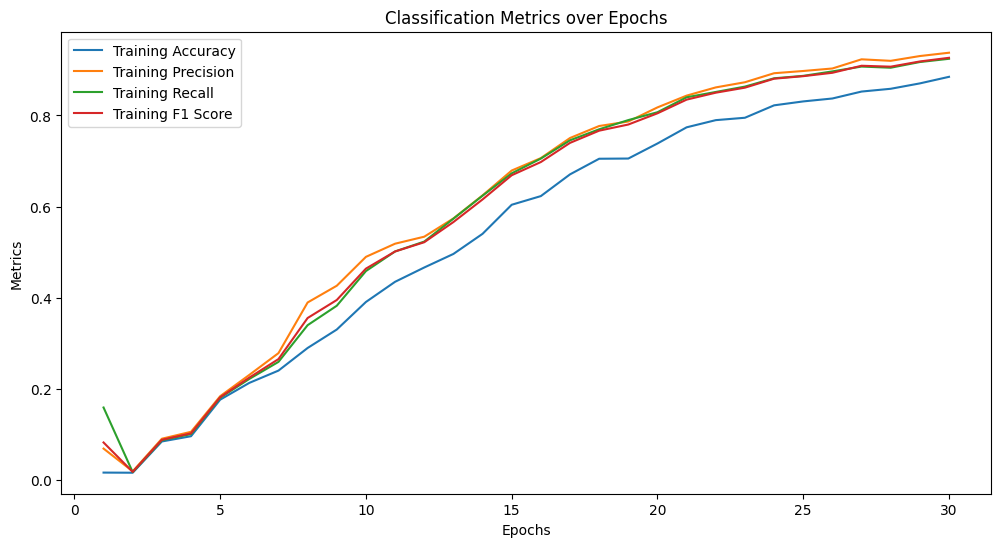

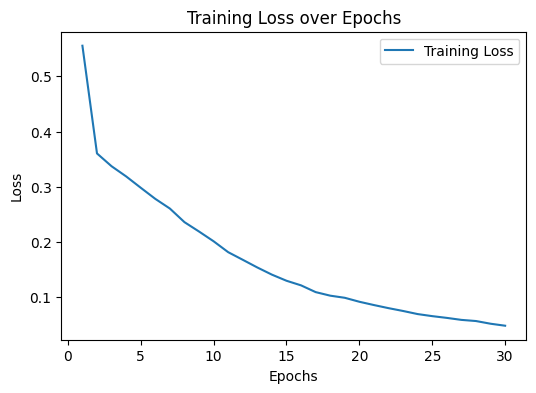

In [21]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_loss_log) + 1))

# График метрик
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_log, label='Training Accuracy')
plt.plot(epochs, train_prec_log, label='Training Precision')
plt.plot(epochs, train_recall_log, label='Training Recall')
plt.plot(epochs, train_f1_log, label='Training F1 Score')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Classification Metrics over Epochs')
plt.legend()
plt.show()

# График функции потерь
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_log, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


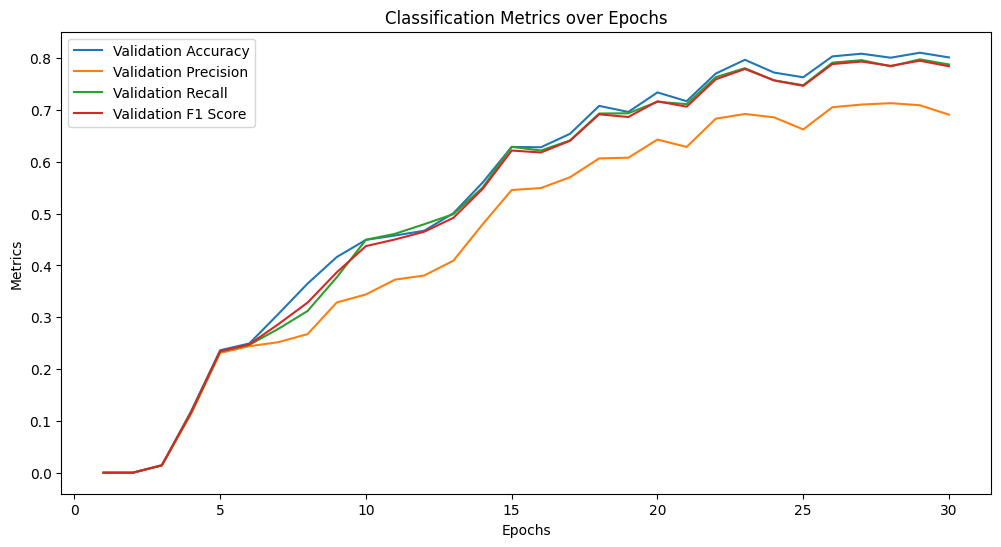

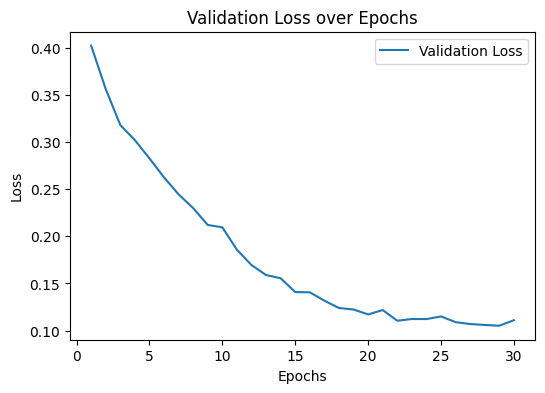

In [22]:

# График метрик
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_acc_log, label='Validation Accuracy')
plt.plot(epochs, val_prec_log, label='Validation Precision')
plt.plot(epochs, val_recall_log, label='Validation Recall')
plt.plot(epochs, val_f1_log, label='Validation F1 Score')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Classification Metrics over Epochs')
plt.legend()
plt.show()

# График функции потерь
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_loss_log, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()